# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = DEFAULT_LINE # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.ZSCORE  # variable of interest for post-processing

### Derived parameters

In [5]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = mouseline
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 28/05/2022 16:56:58: line3 batch notebook started on 2022-05-28 at 16:56:58


### Input summary table figure

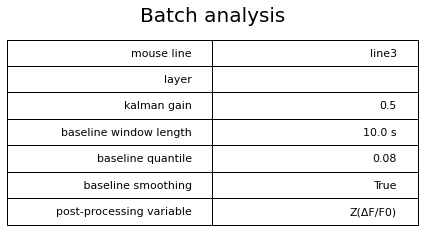

In [6]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

### Load data

In [18]:
logger.info(f'loading data from {trialavg_dir}:')
data = load_processed_datasets(trialavg_dir, include_patterns=layer, exclude_patterns='2021')
timeseries = data['timeseries']
stats = data['stats']
stats

 28/05/2022 17:08:45: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/line3:
 28/05/2022 17:08:45: excluding datasets with the following patterns: ['2021']
 28/05/2022 17:08:45: loading timeseries data from timeseries_20191107_mouse1_region1.csv
 28/05/2022 17:08:46: loading timeseries data from timeseries_20191107_mouse1_region2.csv
 28/05/2022 17:08:46: loading timeseries data from timeseries_20191108_mouse6_region1.csv
 28/05/2022 17:08:47: loading timeseries data from timeseries_20191108_mouse6_region2.csv
 28/05/2022 17:08:48: loading timeseries data from timeseries_20191109_mouse7_region1.csv
 28/05/2022 17:08:49: loading timeseries data from timeseries_20191109_mouse7_region2.csv
 28/05/2022 17:08:50: loading timeseries data from timeseries_20191110_mouse10_region1.csv
 28/05/2022 17:08:51: loading timeseries data from timeseries_20191112_mouse12_region1.csv
 28/05/2022 17:08:51: loading time

line  trial_length  duration (s)   fps  \
dataset                 ROI run                                            
20191107_mouse1_region1 0   0    line3         100.0           0.2  3.56   
                            1    line3         100.0           0.2  3.56   
                            2    line3         100.0           0.2  3.56   
                            3    line3         100.0           0.2  3.56   
                            4    line3         100.0           0.2  3.56   
...                                ...           ...           ...   ...   
20191113_mouse9_region2 702 10   line3         100.0           0.2  3.56   
                            11   line3         100.0           0.2  3.56   
                            12   line3         100.0           0.2  3.56   
                            13   line3         100.0           0.2  3.56   
                            14   line3         100.0           0.2  3.56   

                                 P (MPa)  DC (%)  run ID  I_SPPA (W/cm2)  \
dataset                 ROI run                                            
20191107_mouse1_region1 0   0       0.00    50.0   727.0        0.000000   
                            1       0.10    50.0   725.0        0.309132   
                            2       0.20    50.0   724.0        1.236530   
                            3       0.40    50.0   723.0        4.946119   
                            4       0.05    50.0   726.0        0.077283   
...                                  ...     ...     ...             ...   
20191113_mouse9_region2 702 10      0.80    40.0   903.0       19.784475   
                            11      0.80    50.0   902.0       19.784475   
                            12      0.80    60.0   908.0       19.784475   
                            13      0.80    70.0   909.0       19.784475   
                            14      0.80    80.0   910.0       19.784475   

                                 I_SPTA (W/cm2)  \
dataset                 ROI run                   
20191107_mouse1_region1 0   0          0.000000   
                            1          0.154566   
                            2          0.618265   
                            3          2.473059   
                            4          0.038642   
...                                         ...   
20191113_mouse9_region2 702 10         7.913790   
                            11         9.892238   
                            12        11.870685   
                            13        13.849133   
                            14        15.827580   

                                 peak displacement velocity (um/s)  ...  \
dataset                 ROI run                                     ...   
20191107_mouse1_region1 0   0                             0.426569  ...   
                            1                             0.372674  ...   
                            2                             0.484780  ...   
                            3                             0.449157  ...   
                            4                             0.473671  ...   
...                                                            ...  ...   
20191113_mouse9_region2 702 10                            0.403247  ...   
                            11                            0.389695  ...   
                            12                            0.328396  ...   
                            13                            0.336963  ...   
                            14                            0.599032  ...   

                                 post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) pval  \
dataset                 ROI run                                                        
20191107_mouse1_region1 0   0                                             0.000154     
                            1                                             0.301622     
                            2                                   

### Breakdown per mouse region

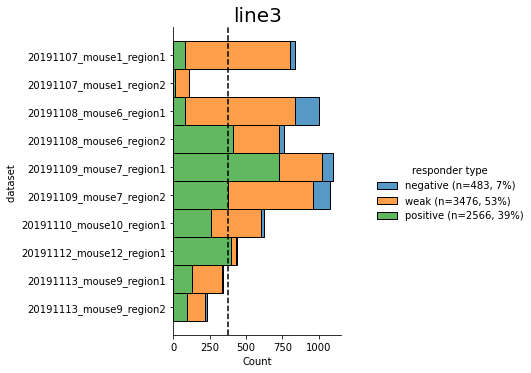

In [8]:
# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = MIN_CELL_DENSITY * area
# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, min_cell_count=min_cell_count,
    title=mouseline)

### Exclude datasets with low cell count

In [9]:
# Idendify datasets with a low overall cell count
celltypes = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = celltypes.groupby(Label.DATASET).count().iloc[:, 0].rename('counts')
to_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Exclude them
data = exclude_datasets(data.copy(), to_exclude)
timeseries = data['timeseries']
stats = data['stats']

 28/05/2022 16:58:58: excluding ['20191107_mouse1_region2', '20191113_mouse9_region1', '20191113_mouse9_region2'] datasets from analysis


### Parameter dependency curves

 28/05/2022 16:59:00: sub-indexing data...
 28/05/2022 16:59:00: filtering data...
 28/05/2022 16:59:00: cross-checking filters...
 28/05/2022 16:59:00: grouping by responder type, grouping by dataset, averaging and plotting mean diff Z(ΔF/F0) vs. P (MPa) ...
 28/05/2022 16:59:01: sub-indexing data...
 28/05/2022 16:59:01: filtering data...
 28/05/2022 16:59:01: cross-checking filters...
 28/05/2022 16:59:01: grouping by responder type, grouping by dataset, averaging and plotting mean diff Z(ΔF/F0) vs. DC (%) ...


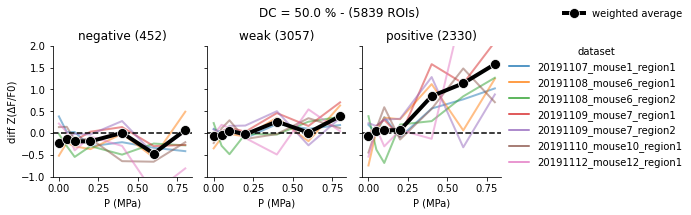

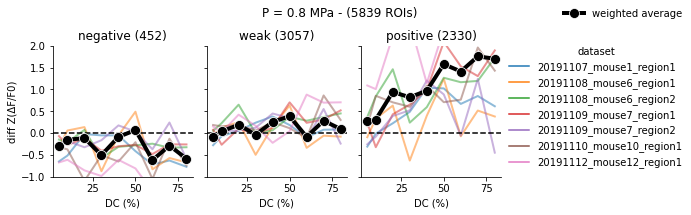

In [10]:
for pkey in [Label.P, Label.DC]:
    figs[f'{pkey}-dep {ykey_postpro}'] = plot_parameter_dependency_across_datasets(
        stats, pkey, Label.ZSCORE)

### Get plot-ready traces dataset

In [11]:
plt_data = get_plot_data(timeseries, stats)

 28/05/2022 16:59:04: merging timeseries and stats information...
 28/05/2022 16:59:45: adding time info to table...


### Pressure-dependent response traces

 28/05/2022 17:01:44: plotting P (MPa) dependency curves for negative responders...
 28/05/2022 17:01:44: sub-indexing data...
 28/05/2022 17:01:44: filtering data...
 28/05/2022 17:01:45: cross-checking filters...
 28/05/2022 17:01:45: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 17:01:48: plotting P (MPa) dependency curves for positive responders...
 28/05/2022 17:01:49: sub-indexing data...
 28/05/2022 17:01:51: filtering data...
 28/05/2022 17:01:52: cross-checking filters...
 28/05/2022 17:01:52: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 17:02:06: plotting P (MPa) dependency curves for weak responders...
 28/05/2022 17:02:08: sub-indexing data...
 28/05/2022 17:02:09: filtering data...
 28/05/2022 17:02:10: cross-checking filters...
 28/05/2022 17:02:11: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


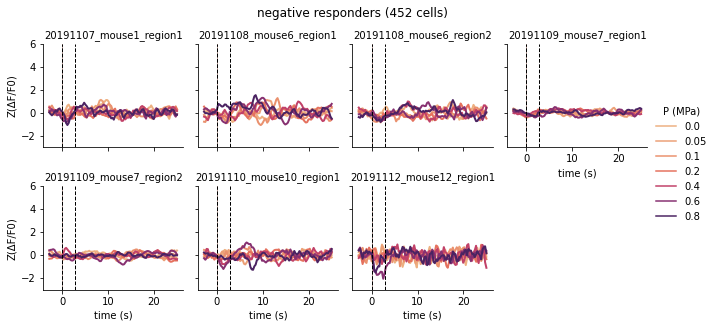

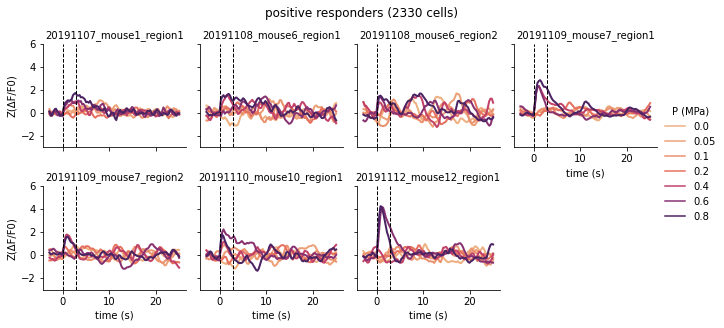

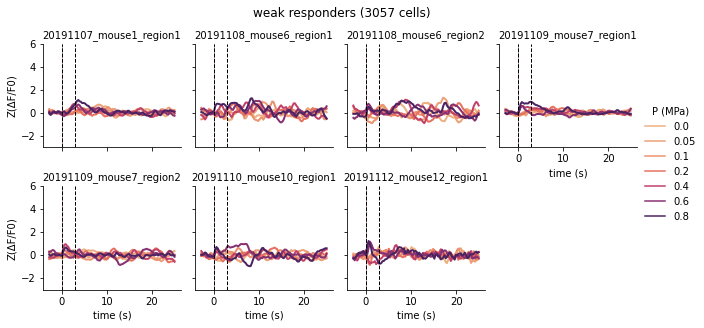

In [12]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 28/05/2022 17:02:33: plotting DC (%) dependency curves for negative responders...
 28/05/2022 17:02:33: sub-indexing data...
 28/05/2022 17:02:33: filtering data...
 28/05/2022 17:02:33: cross-checking filters...
 28/05/2022 17:02:33: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 17:02:37: plotting DC (%) dependency curves for positive responders...
 28/05/2022 17:02:38: sub-indexing data...
 28/05/2022 17:02:39: filtering data...
 28/05/2022 17:02:40: cross-checking filters...
 28/05/2022 17:02:41: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 17:02:58: plotting DC (%) dependency curves for weak responders...
 28/05/2022 17:03:00: sub-indexing data...
 28/05/2022 17:03:01: filtering data...
 28/05/2022 17:03:02: cross-checking filters...
 28/05/2022 17:03:04: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


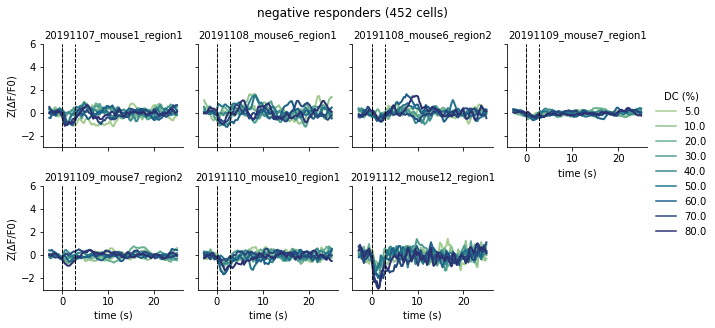

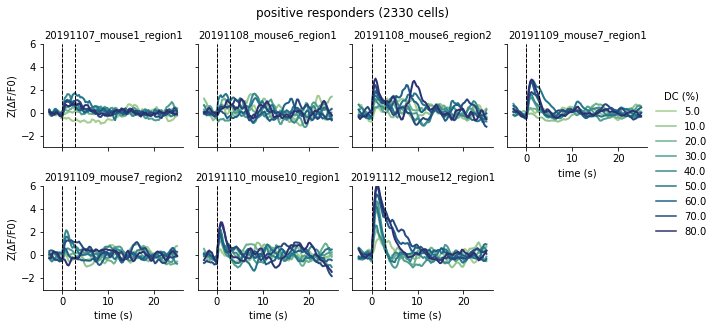

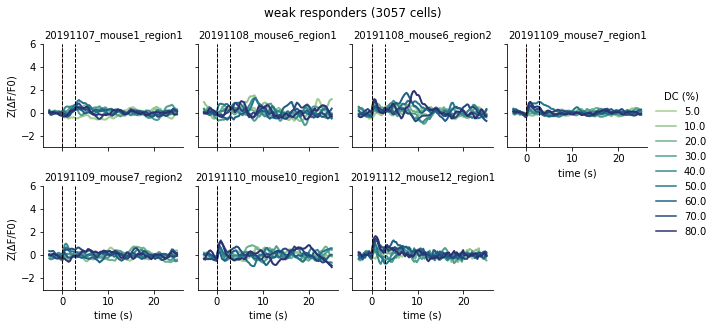

In [13]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 28/05/2022 17:03:27: sub-indexing data...
 28/05/2022 17:03:31: filtering data...
 28/05/2022 17:03:33: cross-checking filters...
 28/05/2022 17:03:35: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 17:04:04: sub-indexing data...
 28/05/2022 17:04:07: filtering data...
 28/05/2022 17:04:09: cross-checking filters...
 28/05/2022 17:04:12: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


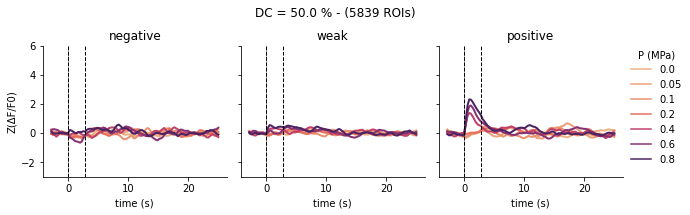

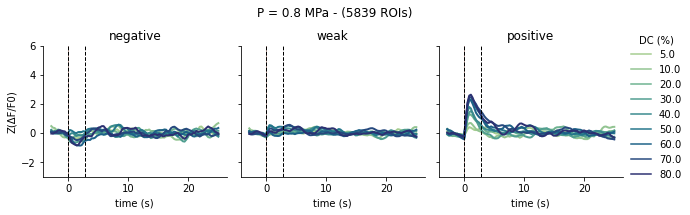

In [14]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 28/05/2022 17:04:51: checking for run order consistency across datasets...
 28/05/2022 17:04:54: computing average traces per dataset and condition...
 28/05/2022 17:04:59: sub-indexing data...
 28/05/2022 17:04:59: filtering data...
 28/05/2022 17:04:59: cross-checking filters...
 28/05/2022 17:04:59: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 28/05/2022 17:05:00: sub-indexing data...
 28/05/2022 17:05:00: filtering data...
 28/05/2022 17:05:00: cross-checking filters...
 28/05/2022 17:05:00: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


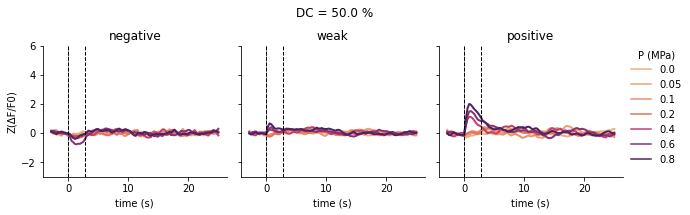

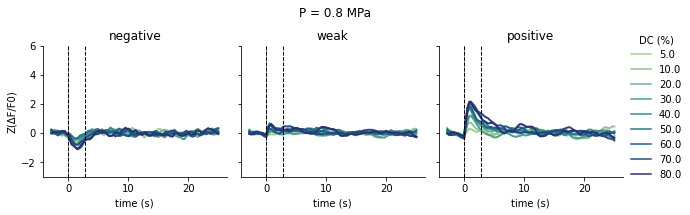

In [15]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [16]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 28/05/2022 17:05:00: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.05.28/figs_line3_k0.5_w10.0s_q0.08_smooth_Z(ΔFF0).pdf:


100%|██████████| 14/14 [00:02<00:00,  6.88it/s]


### Notify upon completion

In [17]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 28/05/2022 17:05:02: line3 batch notebook completed in 0:08:04.417403 s
